# p-mode envelope detection
This is a notebook describing a potential method of evaluating the probability that a p-mode envelope is detected in the power spectrum of a solar-like oscillator.

This method evaluates the probability that a p-mode envelope is present at a $\nu_{max}=\nu_i$ for $i=0,1,2..N$. Where $N$ is the number of frequency bins in the spectrum to be investiaged. 

At each frequency, the power in the spectrum is summed over a range equivalent to the estimated width of a p-mode envelope at that frequency, based on predictions from scaling relations. This summed power is then compared to the sum of the background estimate and a predicted p-mode envelope, with the same width, and where the height of the latter is also estimated from scaling relations.

The only input required is an estimate of of $T_{eff}$ of the star in question and a lightcurve.

### Time series selection
First we select a potential target. KIC8006161 is a solar-like oscillator with numax $\approx3500\mu$Hz. 

In [1]:
import lightkurve as lk
lcs = lk.search_lightcurvefile('KIC8006161', cadence = 'short', mission = 'Kepler').download_all()

/home/nielsemb/.local/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


The downloaded product is a list of lightcurves, one for each quarter (or month for short cadence), which need to be stitched together. This is followed by removing the NaN values in the lightcurve (caused by cosmics for example). 

This star is also fairly active, so in the PDC lightcurve the activity should probably be at least partially filtered with a running median filter. Here we use a filter width of 2001 timesteps, this value is target and/or signal dependent. 

We also remove any outliers at 5 sigma. 

Lightkurve doesn't automatically set the flux units to ppm and zero the mean as we like it, so we also scale the array of flux values.  

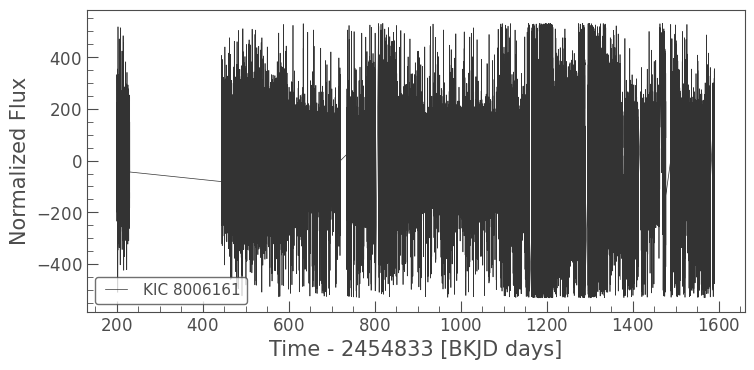

In [2]:
lc  = lcs.PDCSAP_FLUX.stitch().remove_nans().flatten(window_length = 2001).remove_outliers(5)
lc.flux = (lc.flux-1)*1e6 # scale to ppm and zero mean.
lc.plot()

### Power spectrum
Next we compute the power spectrum of the above time series. The power should be normalized to $ppm^2/\mu$Hz, which Lightkurve doesn't do by default.

In [3]:
import numpy as np
pg = lc.to_periodogram(normalization = 'psd') 
dt = np.median(np.diff(lc.time))*86400/1e6
pg.power = pg.power / np.mean(pg.power) * (2*np.std(lc.flux)**2 * dt) 
f, p = pg.frequency.value, pg.power.value

In the following we will also need an estimate of the background level. This can be done using a log(frequency) median filter. Here we use a filter width of 0.1 dex (I think), this value and probably the method too might need to be tweaked. For now we'll just use the Lightkurve method, which you'll see below produces some less-than-optimal results. 

In [4]:
snr, bkg = pg.flatten(filter_width = 0.1, return_trend=True)
b = bkg.power.value

We can plot the resulting power spectrum and the estimate of the background component. A smaller filter_width on the median filter makes the background more senstive to modes in the envelope. On the other hand a wider filter causes the jagged pattern seen near the sharper features in the spectrum. Perhaps a different method of estimating the background can be chosen? Warrick has several. 

Text(0, 0.5, 'PSD [ppm$^2/\\mu$Hz]')

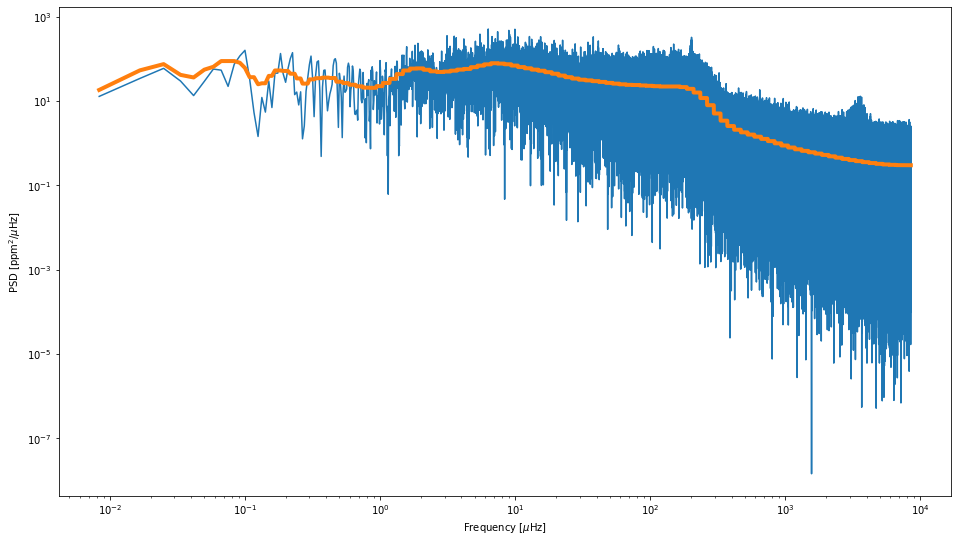

In [5]:
from matplotlib.pyplot import *
fig, ax = subplots(figsize = (16,9))
ax.loglog(f, p, label = 'Power spectrum')
ax.loglog(f, b, label = 'Estimate of the background component of the power', lw = 4)
ax.set_xlabel(r'Frequency [$\mu$Hz]')
ax.set_ylabel(r'PSD [ppm$^2/\mu$Hz]')

The next step is to bin the spectrum. We start by defining a generic binning function.

In [6]:
def bin_this(x, n):
    """ Bin x by a factor n
    
    If len(x) is not equal to an integer number of n, 
    the remaining frequency bins are discarded. 
    Half at low frequency and half at high frequency. 
    
    Parameters
    ----------
    x : array
        Array of values to bin.
    n : int
        Binning factor
    
    Returns
    -------
    xbin : array
        The binned version of the input array
    """
    
    trim = (len(x)//n)*n # The input array isn't always an integer number of the binning factor
    half_rest = (len(x)-trim)//2 
    x = x[half_rest:half_rest+trim] # Trim the input array
    xbin = x.reshape((-1, n)).mean(axis = 1) # reshape and average 
    return xbin

The binning factor is chosen in terms of $\mu$Hz and should be large to smooth out the envelope. Note that small binning factors will make computations very slow. This can be mitigated by refactoring the code below, but we'll leave it like this for clarity. For short cadence binning $>10\mu$Hz or more is probably best(?) at least for now. 

In [1]:
df = f[1]-f[0] # The frequency resolution of the unbinned spectrum

frequency_bin_size = 20 #muHz

Nbin = int(frequency_bin_size / df) # Binning factor

NameError: name 'f' is not defined

We can now bin the arrays

In [8]:
fb = bin_this(f, Nbin) # Binned frequencies
pb = bin_this(p, Nbin) # Binned spectrum
bb = bin_this(b, Nbin) # Binned background estimate

dfb = fb[1] - fb[0] # Frequency resolution after binning

### Computing the predicted p-mode envelopes.
The next step is to compute the predicted p-mode envelopes. This step can probably be optimized considerably, so that a smaller bin-size can be selected above. 

We'll start by defining some functions to generate the predicted envelope based on what we know from the scaling relations.

In [9]:
def pmode_env(f, numax, Teff):
    """ p-mode envelope as a function of frequency.
    
    The p-mode envelope is assumed to be a Guassian.
    
    Parameters
    ----------
    f : array
        Frequency bins in the spectrum
    numax : float
        Frequency to place the p-mode envelope at. 
    Teff : float
        Effective temperature of the star
    
    Returns
    -------
    envelope : array
        Predicted Guassian p-mode envelope.
    """
    
    Henv = env_height(numax, Teff)
    
    stdenv = env_width(numax, Teff)/2 * np.sqrt(2*np.log(2))
    
    envelope = Henv*np.exp(-(f-numax)**2/(2*stdenv**2))
    
    return envelope

def env_height(numax, teff, Henv_sun=0.1):
    """ Scaling relation for the envelope height
    
    Parameters
    ----------
    numax : float
        Frequency of maximum power of the p-mode envelope. 
    teff : float
        Effective temperature of the star
    Henv_sun: float, optional
        Envelope height for the Sun. Default is 0.1 ppm^2/muHz.

    Returns
    -------
    Henv : float
        Height of the p-mode envelope
    """
    
    Tred = 8907.*(numax/3090.)**0.11*(teff/5777.)**-0.47
    
    beta = 1.0 - np.exp(-(Tred-teff)/1250.)
    
    Henv = Henv_sun*beta**2*(numax/3090.)**-2.79*(teff/5777.)**3  
    
    return Henv
    
def env_width(numax, teff):
    """ Scaling relation for the envelope height
    
    Currently just a crude estimate. This can probably 
    be improved.
    
    Parameters
    ----------
    numax : float
        Frequency of maximum power of the p-mode envelope.
    teff : float
        Effective temperature of the star
    
    Returns
    -------    
    width : float
        Envelope width in muHz
    
    """
    if teff <= 5600:
        width = 0.66*numax**0.88
        
    else:
        width = 0.66*numax**0.88*(1+(teff-5777)*6e-4)

    #width = numax/4
    return width

To make a semi-realistic estimate of what the p-mode envelope looks like we need to know the effective temperature of the star. KIC8006161 has a temperature of 5340K. 

We can then proceed to compute the predicted p-mode envelopes for all the frequencies in the binned power spectrum, given that temperature.

In [10]:
Teff = 5340
Hgau = np.array([pmode_env(fb, nu, Teff) for nu in fb])
# Here Hgau is a matrix which can get very slow for small binning factors. 
# Putting this and the following into a for loop would speed things up.

This detection method relies on summing power in a frequency range, equivalent to the expected envelope width,  around a test-value of numax. With the function above we can estimate this frequency range and give it as a boolean array.

Text(0, 0.5, 'Frequency bin number')

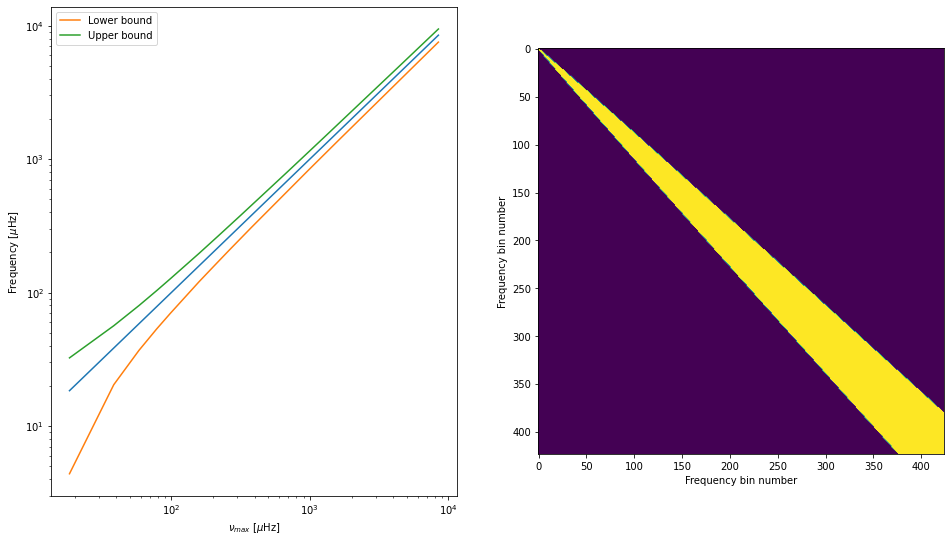

In [11]:
l = fb - (env_width(fb, Teff).astype(int) + dfb)/2  # offset equal to 1 frequency bin to avoid issues at array start and end
u = fb + (env_width(fb, Teff).astype(int) + dfb)/2
env_range = np.array([(l[i] < fb) & (fb < u[i]) for i in range(len(fb))] )

fig, ax = subplots(1,2, figsize = (16,9))
ax[0].loglog(fb,fb)
ax[0].loglog(fb, l, label = 'Lower bound')
ax[0].loglog(fb, u, label = 'Upper bound')
ax[0].set_xlabel(r'$\nu_{max}$ [$\mu$Hz]')
ax[0].set_ylabel(r'Frequency [$\mu$Hz]')
ax[0].legend()
ax[1].imshow(env_range)
ax[1].set_xlabel('Frequency bin number')
ax[1].set_ylabel('Frequency bin number')

The current method for calculating the envelope width is pretty crude, and is currently just a scaling of $\nu_{max}$. A small offset is applied to make sure the envelope width is equal to at least 1 frequency bin. This is only important at low frequencies.

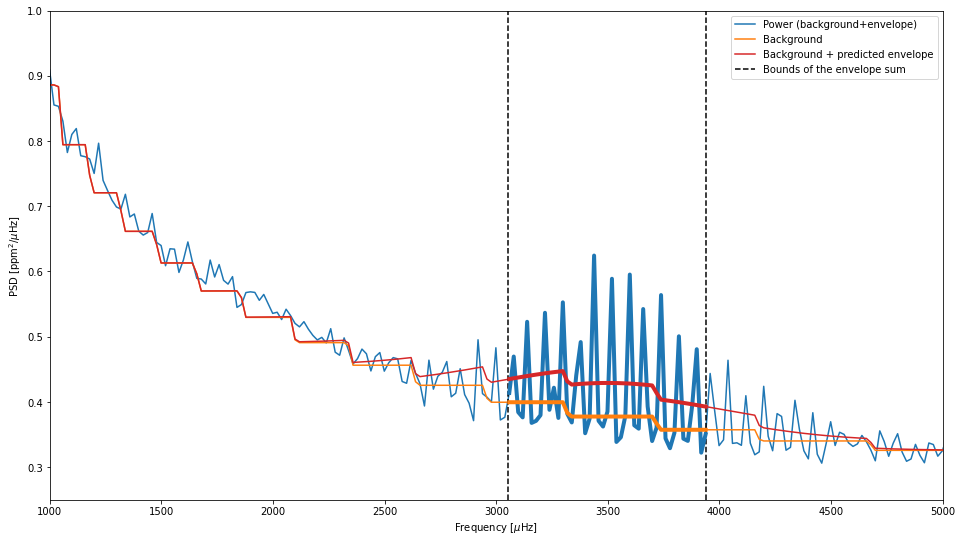

In [12]:
numax = 3500 # for display purposes
idx = np.argmin(abs(fb-numax))

fig, ax = subplots(figsize = (16,9))
ax.plot(fb, pb, label = 'Power (background+envelope)')
ax.plot(fb, bb, label = 'Background', color = 'C1')
ax.plot(fb, bb+Hgau[idx,:], label = 'Background + predicted envelope', color = 'C3')
ax.axvline(l[idx], color = 'k', ls = 'dashed', label = 'Bounds of the envelope sum')
ax.axvline(u[idx], color = 'k', ls = 'dashed')
ax.plot(fb[env_range[idx,:]], pb[env_range[idx,:]], lw = 4, color = 'C0')
ax.plot(fb[env_range[idx,:]], bb[env_range[idx,:]], lw = 4, color = 'C1')
ax.plot(fb[env_range[idx,:]], bb[env_range[idx,:]]+Hgau[idx,env_range[idx,:]], lw = 4, color = 'C3')
ax.set_ylim(0.25, 1.)
ax.set_xlim(1e3,5e3)
ax.set_xlabel(r'Frequency [$\mu$Hz]')
ax.set_ylabel(r'PSD [ppm$^2/\mu$Hz]')
ax.legend()

Above, the dashed black lines indicate the range that is summed over to compute the detection probability. The SNR at the envelope, computed by taking the ratio of the power (blue) to the expected background (orange) is compared to what would be expected from the background and a Gaussian from scaling relations (red). 

**TODO**: The envelope width is perhaps a bit of an underestimate. 

In [13]:
Ptot = np.zeros_like(fb)
Ptot_pred = np.zeros_like(fb)
Btot = np.zeros_like(fb)

for i in range(len(fb)):
    Ptot[i]      = dfb * np.sum(pb[env_range[i]]- bb[env_range[i]])
    Ptot_pred[i] = dfb * np.sum(Hgau[i, env_range[i]])           
    Btot[i]      = dfb * np.sum(bb[env_range[i]])                

SNR      = Ptot / Btot
SNR_pred = Ptot_pred / Btot

We can now plot the above terms to see how they vary with frequency.

Text(0, 0.5, 'Ratio')

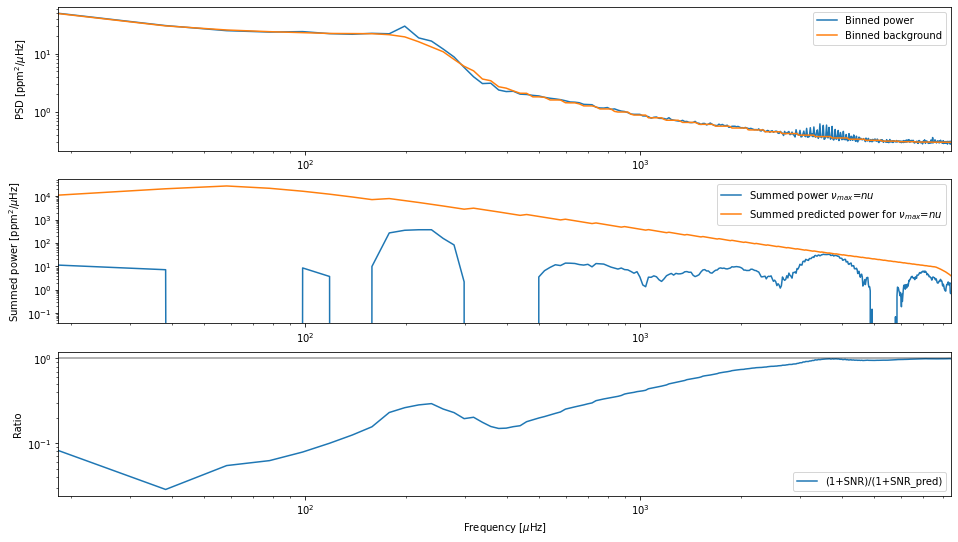

In [14]:
fig, ax = subplots(3,1, figsize = (16,9))
ax[0].loglog(fb, pb, label = 'Binned power')
ax[0].loglog(fb, bb, label = 'Binned background')
ax[0].legend()
ax[0].set_xlim(min(fb), max(fb))
ax[0].set_ylabel(r'PSD [ppm$^2/\mu$Hz]')

ax[1].loglog(fb, Ptot, label = r'Summed power $\nu_{max}$=$nu$')
#ax[1].loglog(fb, Btot, label = r'Summed background for $\nu_{max}$=$nu$')
ax[1].loglog(fb, Ptot_pred, label = r'Summed predicted power for $\nu_{max}$=$nu$')
ax[1].legend()
ax[1].set_xlim(min(fb),max(fb))
ax[1].set_ylabel(r'Summed power [ppm$^2/\mu$Hz]')                 

ax[2].loglog(fb, (1+SNR)/(1+SNR_pred), label = '(1+SNR)/(1+SNR_pred)')
ax[2].axhline(1, color = 'k', alpha = 0.4)
ax[2].legend()
ax[2].set_xlim(min(fb),max(fb))
ax[2].set_xlabel(r'Frequency [$\mu$Hz]')
ax[2].set_ylabel(r'Ratio')                 

The top frame shows the binned power spectrum and the background estimate. 

The middle frame shows the expected power in the p-mode envelope (orange), as a function of frequency, in relation to the sum of the power (blue). The predicted envelope power comes very close to the observed power at the p-mode envelope. 

The bottom frame shows the SNR and the ratio of the SNR and the predicted SNR. 

### Computing the likelihoods

To compute the detection probability at each frequency bin, we establish two hypothesis:
- H0: That the SNR in a frequency bin is consistent with that expected from the background, i.e., it's noise.
- H1: That the SNR in a frequency bin is consistent with the background plus the expected power due to a p-mode envelope at that frequency.

We assume a $\chi^2$ $2N_{bin}$ d.o.f. distribution, so that the likelihood is given by

$p(x|N_{bin}) = \frac{exp(-x)}{\gamma(N_{bin})}x^{N_{bin}-1}$,
where x = 1+SNR.

We use the scipy.stats library to compute the $\chi^2$ statistics. So first a sanity check.

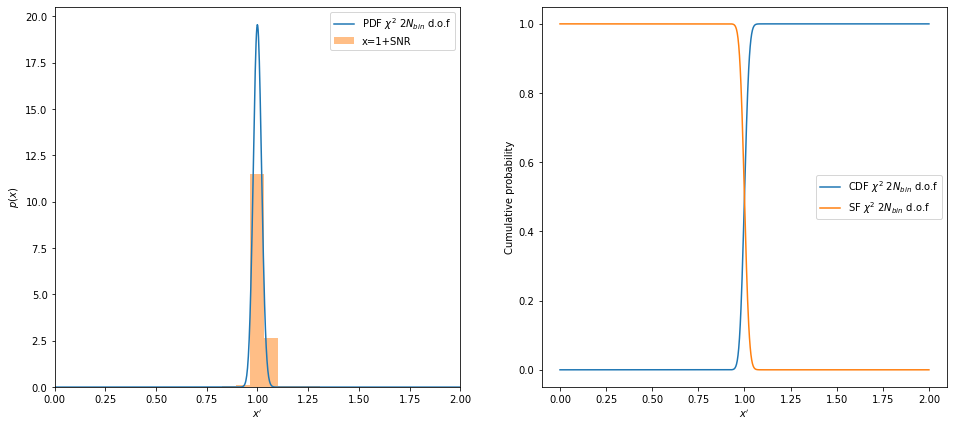

In [15]:
from scipy.stats import chi2

x_prime = np.linspace(0.5,1.5, 1000) 
p = chi2.pdf(x_prime, df=2*Nbin, scale = 1/(2*Nbin)) # pdf of chi^2
c = chi2.cdf(x_prime, df=2*Nbin, scale = 1/(2*Nbin)) # cdf of chi^2
s = chi2.sf(x_prime, df=2*Nbin, scale = 1/(2*Nbin)) # survival function of chi^2 (1-cdf)

fig, ax = subplots(1,2,figsize = (16,7))
ax[0].plot(x_prime, p, label = r'PDF $\chi^2$ $2N_{bin}$ d.o.f')
ax[0].hist(1+SNR, bins = np.linspace(0.5,1.5,30), density=True, alpha = 0.5, label = 'x=1+SNR')
ax[0].set_xlabel("$x'$")
ax[0].set_ylabel('$p(x)$')
ax[0].set_xlim(0.5,1.5)
ax[0].legend()

ax[1].plot(x_prime,c, label = r'CDF $\chi^2$ $2N_{bin}$ d.o.f')
ax[1].plot(x_prime,s, label = r'SF $\chi^2$ $2N_{bin}$ d.o.f')
ax[1].set_xlabel("$x'$")
ax[1].set_ylabel('Cumulative probability')
ax[1].legend()

The number of d.o.f is high, due to the heavy binning of the spectrum ($N_{bin} > 1000$), so the pdf is more or less equal to a Gaussian. There is a small excess in the observed SNR due to the p-mode envelope.

To evaluate the H0 hypothesis, we compute the likelihood that the observed SNR is consistent with the expected chi^2 distributed noise.

That is we evaluate $p(x|N_{bin})$ from above, using the observed SNR values

In [16]:
x = (1+SNR)
like_H0 = chi2.pdf(x=x, df=2*Nbin, scale=1/(2*Nbin))

Next we compute the likelihood of the H1 hypothesis, where we now want to find the likelihood of observing the ratio y = (1+SNR)/(1+SNR_pred). That is, when the observed SNR is equal to the predicted, the probability is highest, whereas when the SNR is higher (maybe some uncorrected signal remains) or lower (there is no p-mode envelope) the probability is low.

In [17]:
y = (1+SNR)/(1+SNR_pred)
like_H1 = chi2.pdf(x=y, df=2*Nbin, scale=1/(2*Nbin)) 

Finally we can evaluate the posterior of the H1 hypothesis by
$p(H1|\mathrm{SNR},\mathrm{SNR}_\mathrm{pred},N_{bin}) = \frac{\mathcal{L}(\mathrm{SNR},\mathrm{SNR}_{\mathrm{pred}},N_{bin}|H1)}{\mathcal{L}(\mathrm{SNR},\mathrm{SNR}_\mathrm{pred},N_{bin}|H1) + \mathcal{L}(\mathrm{SNR},N_{bin}|H0)}$

In [18]:
# Posterior probability of H1
post_H1 = like_H1/(like_H0+like_H1) # 0.5 when H0 and H1 are equally likely, 1 when H0 is 0% likely

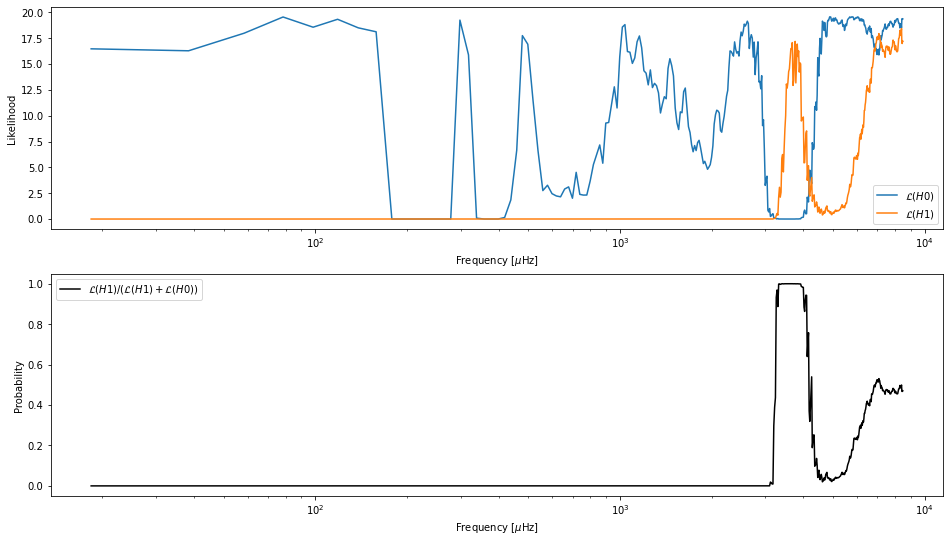

In [19]:
fig, ax = subplots(2,1, figsize = (16,9))
ax[0].plot(fb, like_H0, label = '$\mathcal{L}(H0)$')
ax[0].plot(fb, like_H1, label = '$\mathcal{L}(H1)$')
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency [$\mu$Hz]')
ax[0].set_ylabel('Likelihood')


ax[1].plot(fb, post_H1, color = 'k', label = '$\mathcal{L}(H1) / (\mathcal{L}(H1)+\mathcal{L}(H0))$')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency [$\mu$Hz]')
ax[1].set_ylabel('Probability')
fig.savefig('detection_probability_no_prior.png')

The top frame shows the likelihoods of the H0 and H1 hypothesis. The H0 hypothsis varies quite a bit, in part due to the background no being properly accounted for. Particularly around $220\mu$Hz where the background estimation doesn't capture the sharp features (see spectrum above), and of course at the p-mode envelope which is inconsistent with the background, but is more consistent with the expected power due to the modes. 

At high frequency the signal remains consistent with the background noise, but is also consistent with the predicted SNR, because the scaling relations predict a very shallow envelope at these high frequencies. The posterior here therefore suggests that H0 and H1 are roughly equally likely.

# Computing the prior on H1

We can add a prior to the H1 likelihood, to penalize frequency bins where we don't expect the predicted SNR to exceed a given threshold. That is we can weight the frequency bins which have a predicted power with a low false alarm probability greater than, e.g., 1%.

For a given false alarm probability, we first need to compute the SNR that corresponds to. For this we use the inverse survival function to determine $x=1+\mathrm{SNR}_{thresh}$.

In [20]:
x = chi2.isf(0.01, 2*Nbin, scale=1/(2*Nbin))
SNR_thresh = x-1
print('x=',x)
print('SNR_thresh=',SNR_thresh)

x= 1.048067829640867
SNR_thresh= 0.04806782964086698


Again we'll do a quick sanity check to see what that threshold corresponds to in terms of the pdf we are considering.

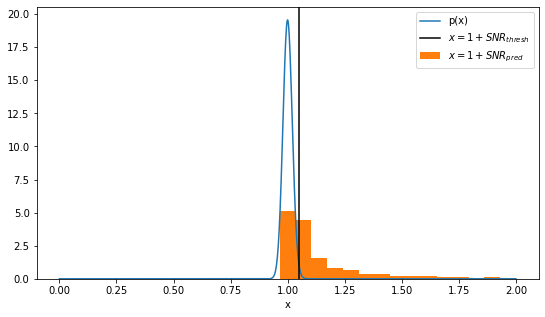

In [21]:
x_prime = np.linspace(0,2, 1000) 
p = chi2.pdf(x_prime, df=2*Nbin, scale = 1/(2*Nbin)) # pdf of chi^2
fig, ax = subplots(figsize = (9,5))
ax.plot(x_prime, p, label= 'p(x)')
ax.hist(1+SNR_pred, bins = np.linspace(0,2,30), density = True, label = '$x=1+SNR_{pred}$')
ax.axvline(1+SNR_thresh, color = 'k', label = '$x=1+SNR_{thresh}$')
ax.set_xlabel('x')
ax.legend()

Above, the black vertical line shows the SNR threshold, compared with the PDF and the predicted SNR (orange). Many of the frequency bins will exceed the threshold, since low frequency bins would correspond to high amplitude oscillations (SG and RG stars). 

We can now compute the probability that the predicted SNR will be higher than the threshold by using the survival function (1-CDF). We can then use this as a prior on H1.

In [22]:
prior_thresh = chi2.sf((1+SNR_thresh)/(1+SNR_pred), 2*Nbin, scale=1/(2*Nbin)) 

epsilon = 1e-10 
prior_H1 = prior_thresh + epsilon
prior_H0 = 1-prior_H1

Note that a small offset is applied to the H1 prior, this avoids problems when p_final is excactly 0. This fudge can be avoided by switching to using the log-pdf versions of the above scipy.stats functions.

We can then compute the posterior for H1 with the prior included by
$p(H1|\mathrm{SNR},\mathrm{SNR}_\mathrm{pred},N_{bin}) = \frac{p(H1)\mathcal{L}(\mathrm{SNR},\mathrm{SNR}_{\mathrm{pred}},N_{bin}|H1)}{p(H1)\mathcal{L}(\mathrm{SNR},\mathrm{SNR}_\mathrm{pred},N_{bin}|H1) + p(H0)\mathcal{L}(\mathrm{SNR},N_{bin}|H0)}$

### Is it correct to add the prior in this way?

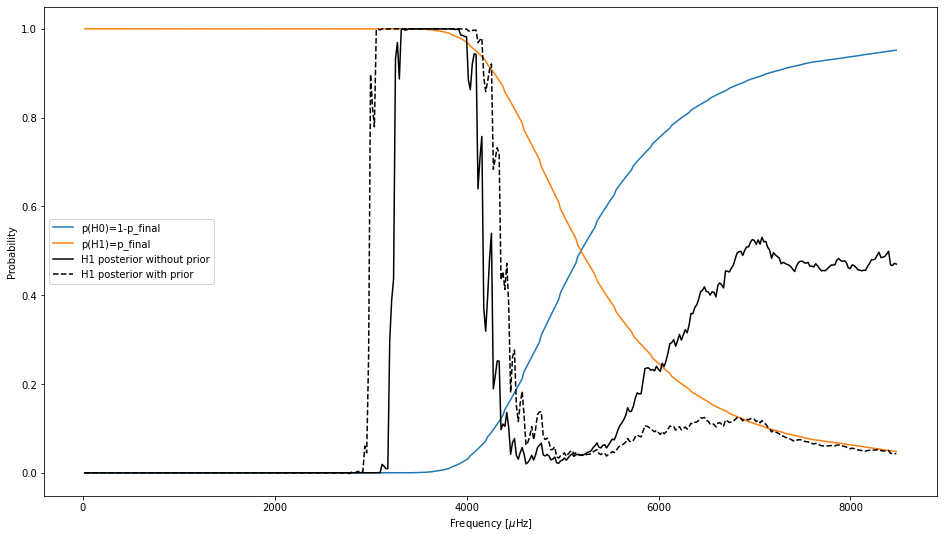

In [23]:
post_H1_w_prior = prior_H1*like_H1/(prior_H0*like_H0+prior_H1*like_H1)

figure(figsize = (16,9))
plot(fb, prior_H0, label = 'p(H0)=1-p_final')
plot(fb, prior_H1, label = 'p(H1)=p_final')
plot(fb, post_H1, color = 'k', label = 'H1 posterior without prior')
plot(fb, post_H1_w_prior, color = 'k', ls = 'dashed', label = 'H1 posterior with prior')
ylabel('Probability')
xlabel('Frequency [$\mu$Hz]')
legend()
savefig('detection_probability_H1_prior.png')

# Adding a prior on numax

We can add an additional prior since we can take a guess at what $\nu_{max}$ should be, based on other observables such as luminosity and temperature. 

As an example, we know that KIC8006161 has a $\nu_{max}\approx3500$, but let's say we're not too confident so we apply wide prior. 

We'll use a log-normal prior centered on the expected $\nu_{max}$, with a height of 1,

$p(\nu_{max}) = exp\left(\frac{-(\ln{\nu}-\mu)^2}{2\sigma^2}\right)$,
where $\mu=\ln{3500}$ is the expected value of $\nu_{max}$ computed from other sources, and $\sigma=1$ is a very conservative uncertainty on that value.

The H1 prior is then computed as:

$p(H1)=p_{final}\,\,p(\nu_{max})$

and

$p(H0)=1-p(H1)$

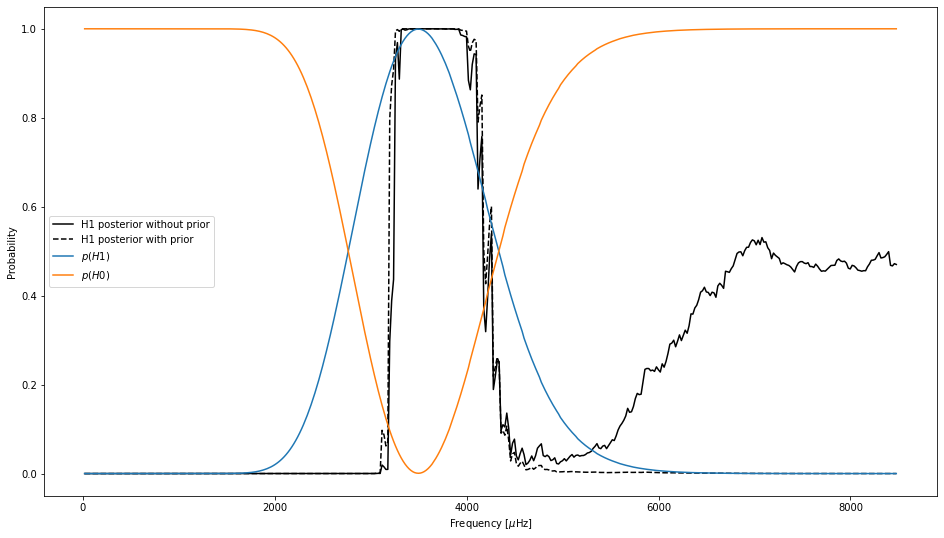

In [24]:
mu = np.log(3500)
sigma = 0.2
prior_numax = np.exp(-(np.log(fb)-mu)**2 / (2*sigma**2))

prior_H1 = prior_thresh*prior_numax
prior_H0 = 1 - prior_H1

post_H1_w_tn_prior = prior_H1*like_H1 / (prior_H0*like_H0 + prior_H1*like_H1)

figure(figsize = (16,9))
plot(fb, post_H1, c= 'k', label = r'H1 posterior without prior')
plot(fb, post_H1_w_tn_prior, ls = 'dashed', c= 'k', label = 'H1 posterior with prior')
plot(fb, prior_H1, color = 'C0', label = r'$p(H1)$')
plot(fb, prior_H0, color = 'C1', label = r'$p(H0)$')
ylabel('Probability')
xlabel('Frequency [$\mu$Hz]')
legend()

This method works really well for the case presented here, and for the most part it seems to work for other targets too. There are however some puzzling cases where the p-mode envelope is abvious but the method doesn't pick them up, even though in very similar cases it does. Clearly this requires further investigation. 